In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from echo_state_tests import gen_in_out_one_in_subs

from scipy.sparse import csr_matrix

/home/fschubert/work/py36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [49]:
N = 500

cf = 0.1
cf_in = .1

W = np.random.normal(0.,1./(cf*N)**.5,(N,N))*(np.random.rand(N,N) <= cf)
W[range(N),range(N)] = 0.

W = csr_matrix(W)

w_in = np.random.normal(0.,1.,(N))*(np.random.rand(N) <= cf_in)

T = 100000

### batch learn w_out
T_batch_w_out = N*4

y_rec_w_out_learn = np.zeros((T_batch_w_out,N+1))

u_out_w_out_learn = np.zeros((T_batch_w_out,1))

tau_batch_w_out = 1.

reg_fact = 0.01
###

y = np.zeros((N+1))
y[0] = 1.
x_r = np.zeros((N))
x_e = np.zeros((N))

a_r = np.ones((N))*0.9
a_e = np.ones((N))*1.

eps_a_r = 0.1
eps_a_e = 0.

err = 0.



### Recording
T_skip_rec = 10

T_rec = int(T/T_skip_rec)

y_rec = np.ndarray((T_rec,N))
x_r_rec = np.ndarray((T_rec,N))
x_e_rec = np.ndarray((T_rec,N))

a_r_rec = np.ndarray((T_rec,N))
a_e_rec = np.ndarray((T_rec,N))

w_out_rec = np.ndarray((T_rec,N+1))

err_rec = np.ndarray((T_rec))
###

In [50]:
w_out = np.random.rand(N+1)-.5

u_in,u_out = gen_in_out_one_in_subs(T,5)

u_out = np.array([u_out]).T

for t in tqdm(range(T)):
    
    x_r = W.dot(y[1:])
    
    x_e = w_in*u_in[t]
    
    y[1:] = np.tanh(a_r*x_r + a_e*x_e)
    
    y_rec_w_out_learn[t%T_batch_w_out,:] = y[:]

    u_out_w_out_learn[t%T_batch_w_out,:] = u_out[t,:]

    O = w_out.dot(y)
    
    if t%T_batch_w_out == 0 and t>0.:
            
            w_out = w_out + (1./tau_batch_w_out)*( -w_out + (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(N+1)) @ y_rec_w_out_learn.T @ u_out_w_out_learn)[:,0])

    err = O - u_out[t,:]
    
    if t >= T_batch_w_out:
        
        
        
        a_r += -eps_a_r * err * w_out[1:] * (1.-y[1:]**2.)*x_r
        a_e += -eps_a_e * err * w_out[1:] * (1.-y[1:]**2.)*x_e
    
    if t%T_skip_rec == 0:

        t_rec = int(t/T_skip_rec)

        y_rec[t_rec,:] = y[1:]
        
        x_r_rec[t_rec,:] = x_r
        x_e_rec[t_rec,:] = x_e

        a_r_rec[t_rec,:] = a_r
        a_e_rec[t_rec,:] = a_e

        w_out_rec[t_rec,:] = w_out

        err_rec[t_rec] = err

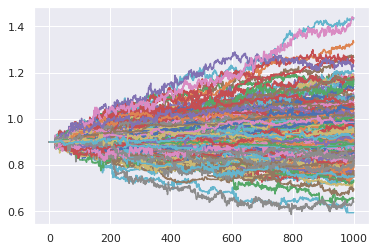

In [53]:
plt.plot(a_r_rec[::10,:])
plt.show()

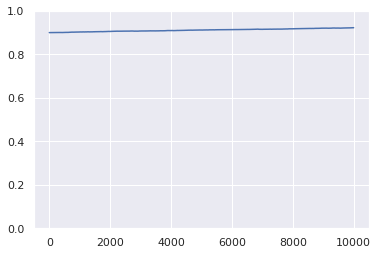

In [52]:
plt.plot((a_r_rec**2.).mean(axis=1)**.5)
plt.ylim([0.,1.])
plt.show()

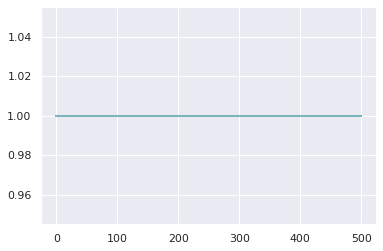

In [46]:
plt.plot(a_e_rec[::100,:])
plt.show()

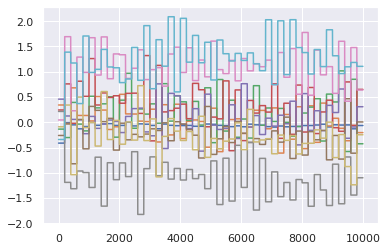

In [54]:
plt.plot(w_out_rec[:,:10])
plt.show()

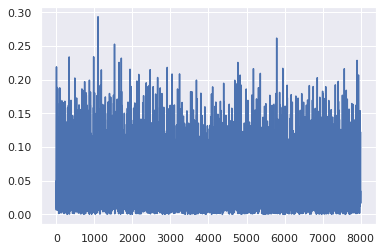

In [56]:
plt.plot((0.5*err_rec[N*4:]**2.)**.5)
plt.show()